# Seedling Image Classification 

In [12]:
import os
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.callbacks import EarlyStopping
# %matplotlib inline

In [15]:
data_path = '../raw_data/images_split/train'

# Loading the dataset using image_dataset_from_directory
batch_size = 32
img_height = 224
img_width = 224

train_dataset = image_dataset_from_directory(
    data_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

validation_dataset = image_dataset_from_directory(
    data_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# Number of classes
num_classes = len(train_dataset.class_names)

# VGG16 preprocessing function
def preprocess(image, label):
    image = preprocess_input(image)  # Preprocess using VGG16's preprocess_input
    return image, label

# Preprocessing to the datasets
train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

# Data augmentation layers
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name="data_augmentation")

# Init model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    data_augmentation,
    vgg16_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Freeze the vgg16 model layers
for layer in vgg16_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model by passing a batch of data
model.build(input_shape=(None, img_height, img_width, 3))

model.summary()

Found 2640 files belonging to 12 classes.
Using 2112 files for training.
Found 2640 files belonging to 12 classes.
Using 528 files for validation.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 128)               3211392   
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                       

In [16]:

# EarlyStopping callback
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[es]
)

Epoch 1/10
66/66 [==============================] - 322s 5s/step - loss: 2.7974 - accuracy: 0.2292 - val_loss: 1.9832 - val_accuracy: 0.3295
Epoch 2/10
66/66 [==============================] - 349s 5s/step - loss: 1.6986 - accuracy: 0.4219 - val_loss: 1.4214 - val_accuracy: 0.5133
Epoch 3/10
66/66 [==============================] - 339s 5s/step - loss: 1.2705 - accuracy: 0.5644 - val_loss: 1.0588 - val_accuracy: 0.6610
Epoch 4/10
66/66 [==============================] - 356s 5s/step - loss: 1.0757 - accuracy: 0.6454 - val_loss: 1.0248 - val_accuracy: 0.6686
Epoch 5/10
66/66 [==============================] - 348s 5s/step - loss: 0.8955 - accuracy: 0.6965 - val_loss: 0.9134 - val_accuracy: 0.6610
Epoch 6/10
66/66 [==============================] - 351s 5s/step - loss: 0.8194 - accuracy: 0.7154 - val_loss: 0.7871 - val_accuracy: 0.7386
Epoch 7/10
66/66 [==============================] - 354s 5s/step - loss: 0.7462 - accuracy: 0.7453 - val_loss: 0.8694 - val_accuracy: 0.7216
Epoch 8/10
66

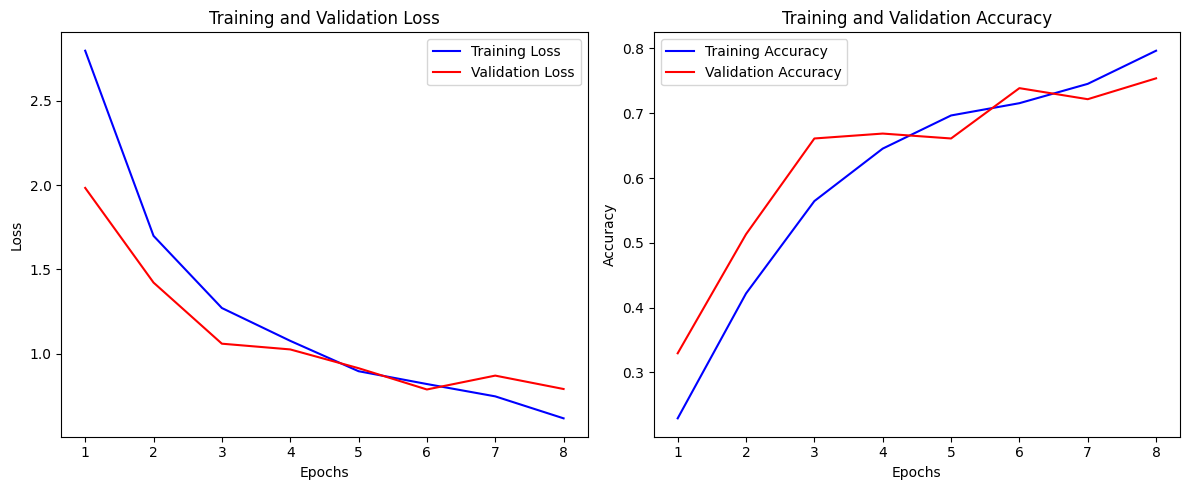

In [17]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
    history: A Keras History object. The history object is the output of a model's fit method.

    Returns:
    None
    """
    # Extracting data from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Plotting the loss graph
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_training_history(history)

In [20]:
test_data_path = '../raw_data/images_split/test'  # Replace with the actual path to your test images

# Load the test dataset using image_dataset_from_directory
test_dataset = image_dataset_from_directory(
    test_data_path,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False  # No need to shuffle for evaluation
)

# Preprocess the test dataset using the same preprocessing function
def preprocess(image, label):
    image = preprocess_input(image)  # Preprocess using VGG16's preprocess_input
    return image, label

# Apply the preprocessing to the test dataset
test_dataset = test_dataset.map(preprocess)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

test_accuracy

Found 384 files belonging to 12 classes.
12/12 [==============================] - 30s 2s/step - loss: 0.9218 - accuracy: 0.7526


0.7526041865348816

In [ ]:
#1

In [21]:
model.save('../models/balanced&augmentated_vgg16_model.keras')